# Import Relevant Libraries and Files

In [1]:
# Obligatory Checking if Runtime Exists
1 + 1

2

In [11]:
import string
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Dropout, GRU
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import TextVectorization
from keras.utils  import to_categorical

In [17]:
data_dir = '../data/'

In [18]:
main_data_directory = data_dir + 'data.json'

In [19]:
data = pd.read_json(main_data_directory,orient='index')

In [16]:
# Possible Answers ONLY: 'JOB', 'COMPANY', 'SKILL'
# This is just a small section for defining what should be predicted throughout the notebook.
# For this research we will be predicting three different prediction types for one model, therefore,
# we need to change this every time we wish to predict a different prediction type.
prediction_type = 'JOB'

In [20]:
# Import Needed Dictionaries

# you can change the directories as needed if you want
role_dic_dir = data_dir + 'role_dictionary_with_predicted_salaries.csv'
skill_dic_dir = data_dir + 'skills_frame_dictionary.csv'
estab_dic_dir = data_dir + 'establishment_dictionary.csv'
education_dic_dir = data_dir + 'education_dictionary.csv'
given_rec_dir = data_dir + 'given_reccomendations_frame_dictionary.csv'
reco_rec_dir = data_dir + 'received_reccomendations_frame_dictionary.csv'

role_dic_frame = pd.read_csv(role_dic_dir)
skill_dic_frame = pd.read_csv(skill_dic_dir)
estab_dic_frame = pd.read_csv(estab_dic_dir)
education_dic_frame = pd.read_csv(education_dic_dir)
given_rec_dic_frame = pd.read_csv(given_rec_dir)
reco_rec_dic_frame = pd.read_csv(reco_rec_dir)

# Pre-Process the Data - Step 1
- Drop the rows in the dataset, in which only one job or establishment exists.
- create new columns which contains the labels that should be predicted (only applies for jobs and establishments. For skills we will try to predict everything)
- Replace all "nan" values with 0 in the calculated duration field.
- convert all relevant columns to lists instead of strings
- reverse all sequences, for easier processing


In [22]:
data

,role_code,establishment_code,calculated_duration,skill_code,education_code,given_reccomendations_codes,received_reccomendations_codes
0,"10394,926,5245","133,133,1184","155.0,489.0,124.0","1062,4861,5827,5828,275,5635,816,286,16,4321,3...",1529,None,None
1,"9028,11756,7829,3627,6407,705,6407,6649,10891","142,142,142,4893,212,212,212,5038,6060","124.0,62.0,93.0,427.0,nan,nan,706.0,124.0,93.0","1525,4926,5025,5022,5011,2053,3703,1124,4766,1...","1194,3143",None,None
2,"8226,10936,1999,2133,3999,8623,6812,4006,3116,...","134,1830,1830,1830,1830,1830,2707,2707,2707,27...","155.0,nan,nan,2073.0,nan,365.0,2617.0,3285.0,4...","6311,846,5673,5675,682,3658,1282,1523,4423,626...",1262,None,None
3,"926,11142,3822","134,3778,2833","155.0,279.0,62.0","3272,6699,6311,1202,3864,1626,5222,2284,676,15...","1448,2310",None,None
4,"8382,7274,1922,4944","134,5812,4801,3978","186.0,1095.0,1250.0,124.0","2849,3421,5118,1569,5198,5951,160,3864,3858,39...","2894,1069,2894",None,None
...,...,...,...,...,...,...,...
4092,"9024,12053,1739,5490,2643,11547","1831,5733,839,1830,5929,6081","1095.0,1646.0,1646.0,1157.0,310.0,186.0","6590,6607,6311,1525,5673",2598,None,None
4093,"11658,9236,1480,10394,10366","1831,134,3472,134,2770","1071.0,823.0,706.0,1071.0,458.0","5460,5525",787,None,None
4094,"2313,7812,10745,7981,6892,7869","1831,5127,2196,6564,144,5647","1250.0,4807.0,4015.0,582.0,730.0,1374.0","6384,5602,5022,5847,5827,3037,5216,5194,5154,4...","2386,2398,2850,2048,1938",None,None
4095,"9014,10498,9014,11658,5289","1831,910,1830,2707,2716","1219.0,365.0,520.0,341.0,186.0","1100,3058,2985,3590,6311,1569,1626,338,945,294...","1687,3189",None,None


In [23]:
# get the max length of each sequence for each rows
data['max_seq_of_jobs'] = data.role_code.str.split(',').map(len)
data['max_seq_of_skills'] = data.skill_code.str.split(',').map(len)

In [24]:
# drop rows with only one job, 
# this will include as well single establishments.
to_remove_indices = data[data['max_seq_of_jobs'] == 1 ].index
data = data.drop(to_remove_indices)

In [25]:
# identify in advance what is the latest job and establishment, this will be used later for the y_labels
data['latest_job'] = data.role_code.str.split(',').str.get(0)
data['latest_establishment'] = data.establishment_code.str.split(',').str.get(0)

In [26]:
# clean the calculated duration column, by replacing "nan" with 0
# this is an existing bug in previous data cleaning, remind carl to fix this.

data['calculated_duration'] = data.calculated_duration.str.replace('nan','0')

In [27]:
# update the max sequence length column again, this has been changed due to to splitting.
data['max_seq_of_jobs'] = data.role_code.str.split(',').map(len)
data['max_seq_of_skills'] = data.skill_code.str.split(',').map(len)
# data['max_seq_of_education'] = data.education_code.str.split(',').map(len)

# To make things a bit easier, reverse the sequence so that the last value of the unpadded sequence is the latest job
# to do this, replace first all columns containing sequences to Python Lists. 
# Once they are lists, you can just execute the reverse() function to reverse the entire sequence for all rows.
data['role_code'] = data.role_code.str.split(',')
data['calculated_duration'] = data.calculated_duration.str.split(',')
data['establishment_code'] = data.establishment_code.str.split(',')
data['skill_code'] = data.skill_code.str.split(',')
data['education_code'] = data.education_code.str.split(',')

In [28]:
def convert_string_list_to_int_list(list_):
  new_list = [float(i) for i in list_]

  return new_list

data['calculated_duration'] = data['calculated_duration'].apply(convert_string_list_to_int_list)

In [29]:
def apply_reverse(row):
  row.reverse()

  return row

# finally apply reverse() to all rows
data['establishment_code'] = data['establishment_code'].apply(apply_reverse)
data['role_code'] = data['role_code'].apply(apply_reverse)
data['calculated_duration'] = data['calculated_duration'].apply(apply_reverse)

In [30]:
# prepare a new column containing predicted_salaries estimations using role_dic_frame
def create_predicted_salaries_column(sequence):
  pred_salary_val = []
  for role_code_ in sequence:

    salary_estimate = role_dic_frame[role_dic_frame['role_code'] == int(role_code_)].iloc[0]

    if not (salary_estimate.isna()['Average/Salary Per Year']):
      pred_salary_val.append(salary_estimate['Average/Salary Per Year'])
    else:
      pred_salary_val.append(0)

  return pred_salary_val


In [31]:
data['predicted_salaries'] = data['role_code'].apply(create_predicted_salaries_column)

In [32]:
def fill_none_with_unknown(seq):
  if not seq:
    return ['@@UNKNOWN@@']
  else:
    return seq

In [33]:
data['given_reccomendations_codes'] = data['given_reccomendations_codes'].apply(fill_none_with_unknown)
data['education_code'] = data['education_code'].apply(fill_none_with_unknown)
data['received_reccomendations_codes'] = data['received_reccomendations_codes'].apply(fill_none_with_unknown)

In [34]:
def split_input(sequence):
    input_text = sequence[:-1]
    return input_text

def split_target(sequence):
    target_text = sequence[1:]
    return target_text

In [35]:
data['x_jobs'] = data['role_code'].apply(split_input)
data['y_jobs'] = data['role_code'].apply(split_target)

data['x_estabs'] = data['establishment_code'].apply(split_input)
data['y_estabs'] = data['establishment_code'].apply(split_target)

In [36]:
data['role_code']

0                                      [5245, 926, 10394]
1       [10891, 6649, 6407, 705, 6407, 3627, 7829, 117...
2       [11982, 5927, 7577, 10212, 5914, 53, 7987, 311...
3                                      [3822, 11142, 926]
4                                [4944, 1922, 7274, 8382]
                              ...                        
4092               [11547, 2643, 5490, 1739, 12053, 9024]
4093                    [10366, 10394, 1480, 9236, 11658]
4094                [7869, 6892, 7981, 10745, 7812, 2313]
4095                     [5289, 11658, 9014, 10498, 9014]
4096         [12093, 12093, 7987, 6344, 9819, 9819, 7849]
Name: role_code, Length: 3991, dtype: object

In [37]:
data['y_jobs']

0                                            [926, 10394]
1        [6649, 6407, 705, 6407, 3627, 7829, 11756, 9028]
2       [5927, 7577, 10212, 5914, 53, 7987, 3116, 4006...
3                                            [11142, 926]
4                                      [1922, 7274, 8382]
                              ...                        
4092                      [2643, 5490, 1739, 12053, 9024]
4093                           [10394, 1480, 9236, 11658]
4094                      [6892, 7981, 10745, 7812, 2313]
4095                           [11658, 9014, 10498, 9014]
4096                [12093, 7987, 6344, 9819, 9819, 7849]
Name: y_jobs, Length: 3991, dtype: object

In [38]:
data['x_jobs']

0                                             [5245, 926]
1       [10891, 6649, 6407, 705, 6407, 3627, 7829, 11756]
2       [11982, 5927, 7577, 10212, 5914, 53, 7987, 311...
3                                           [3822, 11142]
4                                      [4944, 1922, 7274]
                              ...                        
4092                     [11547, 2643, 5490, 1739, 12053]
4093                           [10366, 10394, 1480, 9236]
4094                      [7869, 6892, 7981, 10745, 7812]
4095                           [5289, 11658, 9014, 10498]
4096               [12093, 12093, 7987, 6344, 9819, 9819]
Name: x_jobs, Length: 3991, dtype: object

In [39]:
# after fixing the data to the reverse direction, 
# convert them all back to strings to feed later to the tokenizer
data['establishments'] = data['establishment_code'].apply(lambda x: ' '.join(map(str, x)))
data['jobs'] = data['role_code'].apply(lambda x: ' '.join(map(str, x)))
data['skills'] = data['skill_code'].apply(lambda x: ' '.join(map(str, x)))
data['education'] = data['education_code'].apply(lambda x: ' '.join(map(str, x)))
data['given_reccomendations'] = data['given_reccomendations_codes'].apply(lambda x: ' '.join(map(str, x)))
data['received_reccomendations'] = data['received_reccomendations_codes'].apply(lambda x: ' '.join(map(str, x)))

In [40]:
data['x_jobs'] = data['x_jobs'].apply(lambda x: ' '.join(map(str, x)))
data['y_jobs'] = data['y_jobs'].apply(lambda x: ' '.join(map(str, x)))

In [41]:
data['x_estabs'] = data['x_estabs'].apply(lambda x: ' '.join(map(str, x)))
data['y_estabs'] = data['y_estabs'].apply(lambda x: ' '.join(map(str, x)))

In [42]:
data['y_estabs']

0                                                 133 133
1                       5038 212 212 212 4893 142 142 142
2       5962 2707 2707 2707 2707 2707 2707 2707 2707 1...
3                                                3778 134
4                                           4801 5812 134
                              ...                        
4092                              5929 1830 839 5733 1831
4093                                    134 3472 134 1831
4094                              144 6564 2196 5127 1831
4095                                   2707 1830 910 1831
4096                            756 736 152 1830 1830 581
Name: y_estabs, Length: 3991, dtype: object

In [43]:
data.loc[data['education'] =='@@UNKNOWN@@','education']

11      @@UNKNOWN@@
27      @@UNKNOWN@@
108     @@UNKNOWN@@
195     @@UNKNOWN@@
267     @@UNKNOWN@@
           ...     
3784    @@UNKNOWN@@
3815    @@UNKNOWN@@
3826    @@UNKNOWN@@
3854    @@UNKNOWN@@
3918    @@UNKNOWN@@
Name: education, Length: 105, dtype: object

In [44]:
data.loc[data['education'] =='@@UNKNOWN@@','education'] = ''
data.loc[data['given_reccomendations'] =='@@UNKNOWN@@','given_reccomendations'] = ''
data.loc[data['received_reccomendations'] =='@@UNKNOWN@@','received_reccomendations'] = ''

In [45]:
data[data['given_reccomendations'] != '']

,role_code,establishment_code,calculated_duration,skill_code,education_code,given_reccomendations_codes,received_reccomendations_codes,max_seq_of_jobs,max_seq_of_skills,latest_job,...,x_jobs,y_jobs,x_estabs,y_estabs,establishments,jobs,skills,education,given_reccomendations,received_reccomendations
393,"[5121, 6474, 1245, 1248, 605, 1252]","[3024, 946, 4845, 4845, 6470, 4158]","[217.0, 365.0, 644.0, 675.0, 823.0, 1312.0]","[695, 802, 4926, 780, 3701, 3703, 1470, 3706, ...","[2783, 2232, 878]","367,416","357,416",6,15,1252,...,5121 6474 1245 1248 605,6474 1245 1248 605 1252,3024 946 4845 4845 6470,946 4845 4845 6470 4158,3024 946 4845 4845 6470 4158,5121 6474 1245 1248 605 1252,695 802 4926 780 3701 3703 1470 3706 1271 4132...,2783 2232 878,"3 6 7 , 4 1 6","3 5 7 , 4 1 6"
400,"[1295, 6978, 6270, 6288, 3645, 3646, 4185, 420...","[4473, 4472, 4133, 4133, 4133, 4133, 2589, 413...","[730.0, 613.0, 792.0, 823.0, 458.0, 124.0, 644...","[780, 2423, 725, 3668, 2402, 3658, 2332, 2114,...","[2971, 2164]",415,[@@UNKNOWN@@],15,20,12176,...,1295 6978 6270 6288 3645 3646 4185 4209 3505 6...,6978 6270 6288 3645 3646 4185 4209 3505 6434 3...,4473 4472 4133 4133 4133 4133 2589 4133 4135 4...,4472 4133 4133 4133 4133 2589 4133 4135 4152 4...,4473 4472 4133 4133 4133 4133 2589 4133 4135 4...,1295 6978 6270 6288 3645 3646 4185 4209 3505 6...,780 2423 725 3668 2402 3658 2332 2114 2313 138...,2971 2164,4 1 5,
404,"[8698, 8688, 8696, 8697, 9882, 7409, 3739, 209...","[6888, 4689, 4689, 4689, 4689, 6456, 4471, 374...","[124.0, 365.0, 279.0, 279.0, 427.0, 1250.0, 52...","[5044, 3701, 257, 3713, 1569, 5186, 5198, 4926...","[423, 2518]","36,188,387","25,191",11,20,774,...,8698 8688 8696 8697 9882 7409 3739 2091 2087 4102,8688 8696 8697 9882 7409 3739 2091 2087 4102 774,6888 4689 4689 4689 4689 6456 4471 3747 3747 4157,4689 4689 4689 4689 6456 4471 3747 3747 4157 4157,6888 4689 4689 4689 4689 6456 4471 3747 3747 4...,8698 8688 8696 8697 9882 7409 3739 2091 2087 4...,5044 3701 257 3713 1569 5186 5198 4926 3697 11...,423 2518,"3 6 , 1 8 8 , 3 8 7","2 5 , 1 9 1"
410,"[5289, 8400, 8400, 2277, 7139, 2288, 5033, 714...","[107, 5584, 5356, 5356, 5356, 5356, 3749, 5356...","[93.0, 489.0, 365.0, 248.0, 644.0, 279.0, 365....","[2848, 5118, 5590, 5890, 1997, 3303, 4224, 168...",[547],144,[@@UNKNOWN@@],10,20,11207,...,5289 8400 8400 2277 7139 2288 5033 7141 11224,8400 8400 2277 7139 2288 5033 7141 11224 11207,107 5584 5356 5356 5356 5356 3749 5356 5356,5584 5356 5356 5356 5356 3749 5356 5356 4158,107 5584 5356 5356 5356 5356 3749 5356 5356 4158,5289 8400 8400 2277 7139 2288 5033 7141 11224 ...,2848 5118 5590 5890 1997 3303 4224 1686 6212 4...,547,1 4 4,
431,"[7772, 3202, 6232, 3212, 3151, 6653]","[5171, 4157, 4157, 4157, 4157, 4321]","[2679.0, 916.0, 0.0, 0.0, 0.0, 0.0]","[4774, 4096, 1920, 3681, 1914, 3658, 6055, 147...",[997],12,6,6,20,6653,...,7772 3202 6232 3212 3151,3202 6232 3212 3151 6653,5171 4157 4157 4157 4157,4157 4157 4157 4157 4321,5171 4157 4157 4157 4157 4321,7772 3202 6232 3212 3151 6653,4774 4096 1920 3681 1914 3658 6055 1470 2954 4...,997,1 2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,"[2956, 511, 9927, 492]","[3170, 2374, 6008, 826]","[124.0, 1281.0, 458.0, 93.0]","[3254, 4595, 1479, 4250, 272, 1206, 1621, 2621...","[859, 2654]",286,164,4,20,492,...,2956 511 9927,511 9927 492,3170 2374 6008,2374 6008 826,3170 2374 6008 826,2956 511 9927 492,3254 4595 1479 4250 272 1206 1621 2621 6780 58...,859 2654,2 8 6,1 6 4
3096,"[8635, 3889, 12093, 10109]","[2074, 1097, 745, 825]","[2834.0, 3199.0, 3991.0, 1825.0]","[780, 802, 4291, 3713, 4934, 544, 3658, 3077, ...",[2679],257,[@@UNKNOWN@@],4,20,10109,...,8635 3889 12093,3889 12093 10109,2074 1097 745,1097 745 825,2074 1097 745 825,8635 3889 12093 10109,780 802 4291 3713 4934 544 3658 3077 4461 3703...,2679,2 5 7,
3114,"[2619, 9418, 11713]","[57, 6304, 825]","[365.0, 823.0, 1250.0]","[6435, 6436, 1525, 5337, 2337, 1427, 6132, 648...",[394],0,[@@UNKNOWN@@],3,9,1

# Pre-Process the Data - Step 2 - Prepare the Tokenizers and Tokenize Everything

- prepare tokenizers for all 3 types so that we can convert it to a more machine readable format. Tokenizers will be good to use as well to turn it back to the appropriate value before it became a token.
- Remove the latest job/company in the sequence (This will be done only for predicting skills and jobs).
- convert all sequences that will be feed to the model as padded sequences.
- convert all y_labels to padded sequences.

In [46]:
# Tokenizer() is already deprecated. I used TextVectorization Layer instead. 
# its the same use but the updated one. Did this to avoid any potential issues caused by deprecation.
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
# Notice of Deprecation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

MAX_SEQUENCE_LENGTH = 30
job_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=role_dic_frame['role_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

skill_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=skill_dic_frame['skill_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

estab_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=estab_dic_frame['establishment_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

job_vectorize_layer_without_padding = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=role_dic_frame['role_code'].apply(str).tolist(),
)

education_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=education_dic_frame['education_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

giv_rec_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=given_rec_dic_frame['reccomendation_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)
reco_rec_vectorize_layer = TextVectorization(
    standardize=None,
    output_mode='int',
    vocabulary=reco_rec_dic_frame['reccomendation_code'].apply(str).tolist(),
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

2023-06-02 23:54:13.949967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 23:54:13.995639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 23:54:13.996168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 23:54:14.001725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [49]:
tokenized_jobs = job_vectorize_layer(data['jobs'])
tokenized_skills = skill_vectorize_layer(data['skills'])
tokenized_estabs = estab_vectorize_layer(data['establishments'])
tokenized_educ = education_vectorize_layer(data['education'])
tokenized_giv_rec = giv_rec_vectorize_layer(data['given_reccomendations'])
tokenized_reco_rec = reco_rec_vectorize_layer(data['received_reccomendations'])


tokenized_x_estabs = estab_vectorize_layer(data['x_estabs'])
tokenized_x_jobs = job_vectorize_layer(data['x_jobs'])

In [50]:
# things you can use to convert tokenized outputs back to their original form
INDEX = 0
estab_vectorize_layer.get_vocabulary()[INDEX]

''

In [51]:
for i in tokenized_reco_rec.numpy():
  if np.any(np.isnan(i)):
    print('hi')

In [52]:
jobs_vocab = len(job_vectorize_layer.get_vocabulary())
skills_vocab = len(skill_vectorize_layer.get_vocabulary())
estab_vocab = len(estab_vectorize_layer.get_vocabulary())
education_vocab = len(education_vectorize_layer.get_vocabulary())

print("Skills is of {} unique words".format(skills_vocab))
print("Jobs is of {} unique words".format(jobs_vocab))
print("Establishments is of {} unique words".format(estab_vocab))
print("Education is of {} unique words".format(education_vocab))

Skills is of 7005 unique words
Jobs is of 12378 unique words
Establishments is of 6939 unique words
Education is of 3217 unique words


In [53]:
if prediction_type == 'JOB':
  vocab_size = jobs_vocab
elif prediction_type == 'COMPANY':
  vocab_size = estab_vocab
elif prediction_type == 'SKILL':
  vocab_size = skills_vocab

In [54]:
vocab_size

12378

In [55]:
tokenized_jobs.shape

TensorShape([3991, 30])

In [56]:
tokenized_y_skills = skill_vectorize_layer(data['skills'])
tokenized_y_estabs = estab_vectorize_layer(data['y_estabs'])
tokenized_y_jobs = job_vectorize_layer(data['y_jobs'])

In [57]:
tokenized_y_jobs

<tf.Tensor: shape=(3991, 30), dtype=int64, numpy=
array([[    3,     2,     0, ...,     0,     0,     0],
       [   11,     9,    10, ...,     0,     0,     0],
       [   27,    26,    25, ...,     0,     0,     0],
       ...,
       [12372, 12371, 12370, ...,     0,     0,     0],
       [ 1003,  7048, 12374, ...,     0,     0,     0],
       [ 7752,    22, 12377, ...,     0,     0,     0]])>

In [58]:
# create tensors for job duration and salary estimates

padded_calculated_duration = tf.keras.preprocessing.sequence.pad_sequences(
    data['calculated_duration'], padding="post",maxlen=MAX_SEQUENCE_LENGTH,
)
calculated_duration_norm = tf.convert_to_tensor(padded_calculated_duration)

padded_salaries = tf.keras.preprocessing.sequence.pad_sequences(
    data['predicted_salaries'], padding="post",maxlen=MAX_SEQUENCE_LENGTH,
)
salaries_norm = tf.convert_to_tensor(padded_salaries)


In [59]:
padded_calculated_duration

array([[ 124,  489,  155, ...,    0,    0,    0],
       [  93,  124,  706, ...,    0,    0,    0],
       [3285, 3168,  248, ...,    0,    0,    0],
       ...,
       [1374,  730,  582, ...,    0,    0,    0],
       [ 186,  341,  520, ...,    0,    0,    0],
       [2772, 1157,  427, ...,    0,    0,    0]], dtype=int32)

In [60]:
tf.keras.preprocessing.sequence.pad_sequences(
    padded_calculated_duration, padding="post",maxlen=MAX_SEQUENCE_LENGTH,
)

array([[ 124,  489,  155, ...,    0,    0,    0],
       [  93,  124,  706, ...,    0,    0,    0],
       [3285, 3168,  248, ...,    0,    0,    0],
       ...,
       [1374,  730,  582, ...,    0,    0,    0],
       [ 186,  341,  520, ...,    0,    0,    0],
       [2772, 1157,  427, ...,    0,    0,    0]], dtype=int32)

In [66]:
layer_duration_norm = tf.keras.layers.Normalization(
  axis=None,
  # mean=2.0, variance=1.0
)
layer_salaries_norm = tf.keras.layers.Normalization(
  axis=None,
  # mean=2.0, variance=1.0
)

In [74]:
duration_dir = data_dir+ 'durations_dictionary.csv'

duration_frame = pd.read_csv(duration_dir)

duration_frame = duration_frame[duration_frame['calculated_duration'].notna()]

salaries_dir = data_dir + 'predicted_salaries_dictionary.csv'

salaries_dict_frame = pd.read_csv(salaries_dir)

salaries_dict_frame = salaries_dict_frame[salaries_dict_frame['Average/Salary Per Year'].notna()]

In [79]:
layer_duration_norm.adapt(duration_frame['calculated_duration'].to_numpy())
layer_salaries_norm.adapt(salaries_dict_frame['Average/Salary Per Year'].to_numpy())

In [80]:
calculated_duration = layer_duration_norm(padded_calculated_duration)

In [81]:
calculated_duration

<tf.Tensor: shape=(3991, 30), dtype=float32, numpy=
array([[-0.750578  , -0.38455474, -0.71949106, ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ],
       [-0.7816649 , -0.750578  , -0.1669464 , ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ],
       [ 2.4192836 ,  2.3019557 , -0.62623036, ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ],
       ...,
       [ 0.5029263 , -0.14287911, -0.291294  , ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ],
       [-0.6884042 , -0.53296965, -0.35346782, ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ],
       [ 1.9048455 ,  0.28531796, -0.44672856, ..., -0.8749256 ,
        -0.8749256 , -0.8749256 ]], dtype=float32)>

In [82]:
padded_calculated_duration

array([[ 124,  489,  155, ...,    0,    0,    0],
       [  93,  124,  706, ...,    0,    0,    0],
       [3285, 3168,  248, ...,    0,    0,    0],
       ...,
       [1374,  730,  582, ...,    0,    0,    0],
       [ 186,  341,  520, ...,    0,    0,    0],
       [2772, 1157,  427, ...,    0,    0,    0]], dtype=int32)

In [83]:
salaries = layer_salaries_norm(padded_salaries)

In [84]:
salaries

<tf.Tensor: shape=(3991, 30), dtype=float32, numpy=
array([[-0.81265104, -0.07242355,  2.1214633 , ..., -0.81265104,
        -0.81265104, -0.81265104],
       [-0.81265104, -0.81265104, -0.81265104, ..., -0.81265104,
        -0.81265104, -0.81265104],
       [-0.81265104, -0.81265104, -0.81265104, ..., -0.81265104,
        -0.81265104, -0.81265104],
       ...,
       [-0.81265104, -0.81265104, -0.81265104, ..., -0.81265104,
        -0.81265104, -0.81265104],
       [-0.81265104, -0.81265104, -0.81265104, ..., -0.81265104,
        -0.81265104, -0.81265104],
       [-0.81265104, -0.81265104, -0.81265104, ..., -0.81265104,
        -0.81265104, -0.81265104]], dtype=float32)>

# Define Datasets for All Prediction Types for *Use*

In [85]:
def define_dataset(train_dict, train_target_tensor,BUFFER_SIZE=500,BATCH_SIZE=64):
  full_dataset = tf.data.Dataset.from_tensor_slices((train_dict,
                                                        train_target_tensor)).cache()

  DATASET_SIZE = len(full_dataset)

  train_size = int(0.7 * DATASET_SIZE)
  val_size = int(0.15 * DATASET_SIZE)
  test_size = int(0.15 * DATASET_SIZE)

  full_dataset = full_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=False)

  train_dataset = full_dataset.take(train_size)
  test_dataset = full_dataset.skip(train_size)
  val_dataset = test_dataset.skip(val_size)
  test_dataset = test_dataset.take(test_size)

  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset.batch(BATCH_SIZE)

  return train_dataset, test_dataset, val_dataset

In [86]:
# Dataset for Predicting Jobs

# define a dataset object for training and perform a train and test split
train_dict = {
    'jobs': tokenized_x_jobs,
    'skills': tokenized_skills,
    'establishments':tokenized_estabs,
    'education': tokenized_educ,
    'salaries':salaries,
    'duration':calculated_duration,
    'given_recos':tokenized_giv_rec,
    'received_recos':tokenized_reco_rec,
}
train_target_tensor = tokenized_y_jobs # replace as needed depending on the prediction type

jobs_train_dataset, jobs_test_dataset, jobs_val_dataset = define_dataset(
    train_dict,
    train_target_tensor
)

In [87]:
# Dataset for Predicting Companies

# define a dataset object for training and perform a train and test split
train_dict = {
    'jobs': tokenized_jobs,
    'skills': tokenized_skills,
    'establishments':tokenized_x_estabs,
    'education': tokenized_educ,
    'salaries':salaries,
    'duration':calculated_duration,
    'given_recos':tokenized_giv_rec,
    'received_recos':tokenized_reco_rec,
}
train_target_tensor = tokenized_y_estabs # replace as needed depending on the prediction type

estabs_train_dataset, estabs_test_dataset, estabs_val_dataset = define_dataset(
    train_dict,
    train_target_tensor
)

In [88]:
for i in estabs_train_dataset.take(1):
  print(i[1])

tf.Tensor(
[[ 994  993  154 ...    0    0    0]
 [1131    0    0 ...    0    0    0]
 [   2    0    0 ...    0    0    0]
 ...
 [1378    0    0 ...    0    0    0]
 [ 280    9    0 ...    0    0    0]
 [1322 1185 1232 ...    0    0    0]], shape=(64, 30), dtype=int64)


2023-06-02 23:59:23.351861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [89]:
# Dataset for Predicting Skills

# define a dataset object for training and perform a train and test split
train_dict = {
    'jobs': tokenized_jobs,
    'establishments':tokenized_estabs,
    'education': tokenized_educ,
    'salaries':salaries,
    'duration':calculated_duration,
    'given_recos':tokenized_giv_rec,
    'received_recos':tokenized_reco_rec,
}
train_target_tensor = tokenized_y_skills # replace as needed depending on the prediction type

skills_train_dataset, skills_test_dataset, skills_val_dataset = define_dataset(
    train_dict,
    train_target_tensor
)

In [90]:
if prediction_type == 'JOB':
  train_dataset = jobs_train_dataset
elif prediction_type == 'COMPANY':
  train_dataset = estabs_train_dataset
elif prediction_type == 'SKILL':
  train_dataset = skills_train_dataset

In [91]:
if prediction_type == 'JOB':
  test_dataset = jobs_test_dataset
elif prediction_type == 'COMPANY':
  test_dataset = estabs_test_dataset
elif prediction_type == 'SKILL':
  test_dataset = skills_test_dataset

In [92]:
# a loss function to ignore padding values IF IT EXISTS
def loss_function(real, pred):
    """
    We redefine our own loss function in order to get rid of the '0' value
    which is the one used for padding. This to avoid that the model optimize itself
    by predicting this value because it is the padding one.
    
    :param real: the truth
    :param pred: predictions
    :return: a masked loss where '0' in real (due to padding)
                are not taken into account for the evaluation
    """

    # to check that pred is numric and not nan
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                 reduction='none')
    loss_ = loss_object_(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Define the first model, LSTM-ATT Model

In [108]:
# Defining the model

# Define Functional Model
inputs = {}

inputs['jobs']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='jobs'
)
inputs['skills'] = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='skills'
)
inputs['establishments']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='establishments'
)
inputs['education']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='education'
)
inputs['salaries']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='salaries'
)
inputs['duration']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='duration'
)
inputs['given_recos']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='given_recos'
)
inputs['received_recos']  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='received_recos'
)

skills_embedding = keras.layers.Embedding(
    input_dim=skills_vocab,
    output_dim =480,
    mask_zero=True, # Defining the Embeddings with mask_zero = True, https://www.tensorflow.org/guide/keras/masking_and_padding
)(inputs['skills'])
jobs_embedding = keras.layers.Embedding(
    input_dim=jobs_vocab,
    output_dim =128,
    mask_zero=True, # Defining the Embeddings with mask_zero = True, to remove its relevance in the computation https://www.tensorflow.org/guide/keras/masking_and_padding
)(inputs['jobs'])
establishment_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =384,
    mask_zero=True,
)(inputs['establishments'])
education_embedding = keras.layers.Embedding(
    input_dim=education_vocab,
    output_dim =128,
    mask_zero=True,
)(inputs['education'])
salaries_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(inputs['salaries'])
duration_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(inputs['duration'])
given_recos_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(inputs['given_recos'])
received_recos_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(inputs['received_recos'])

merged = keras.layers.Concatenate()([
    skills_embedding,
    jobs_embedding, 
    establishment_embedding,
    education_embedding,
    salaries_embedding,
    duration_embedding,
    given_recos_embedding,
    received_recos_embedding,
])

merged = tf.keras.layers.BatchNormalization(
  name='batchnorm_inputs')(merged)

rnn = tf.keras.layers.LSTM(
    units=64,
    return_sequences=True,
    stateful=False,
    recurrent_initializer='glorot_normal',
    name='LSTM_cat'
)(merged)

rnn = tf.keras.layers.BatchNormalization(name='batchnorm_lstm')(rnn)

att = tf.keras.layers.Attention(use_scale=False, causal=True,
                                name='attention')(inputs=[rnn, rnn])

outputs = keras.layers.Dense(vocab_size,name="rec1_output")(att)

model_trial_2 = keras.Model(
    inputs,
    outputs,
    name="seq2seq_model_trial_with_lstm_high_dimensions",
)

In [109]:
model_trial_2.summary()

Model: "seq2seq_model_trial_with_lstm_high_dimensions"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 skills (InputLayer)            [(None, 30)]         0           []                               
                                                                                                  
 jobs (InputLayer)              [(None, 30)]         0           []                               
                                                                                                  
 establishments (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 education (InputLayer)         [(None, 30)]         0           []                               
                                                      

In [110]:
metrics = ["sparse_categorical_accuracy"]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = model_trial_2
model.compile(loss=loss_function, metrics=metrics,steps_per_execution=1)

In [111]:
print(prediction_type)
history = model.fit(
    train_dataset,
    epochs=5,
    verbose=2,
)

JOB
Epoch 1/5


2023-06-03 00:03:36.758003: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce MX110" frequency: 1006 num_cores: 2 environment { key: "architecture" value: "5.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1048576 shared_memory_size_per_multiprocessor: 65536 memory_size: 1696595968 bandwidth: 40080000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-06-03 00:03:38.580669: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-06-03 00:03:38.583827: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: lib

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_16' defined at (most recent call last):
    File "/home/randomuser/miniconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/randomuser/miniconda3/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_158924/2732543686.py", line 12, in <module>
      verbose=2,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1169, in _internal_apply_gradients
      grads_and_vars,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1217, in _distributed_apply_gradients_fn
      var, apply_grad_to_update_var, args=(grad,), group=False
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_16'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_16}}]] [Op:__inference_train_function_31404]

# Define the second model,  Hybrid CNN Model

In [100]:
from keras import layers

In [101]:
# Defining the model

inputs_jobs  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='jobs'
)
inputs_skills = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='skills'
)
inputs_establishments  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='establishments'
)
input_education  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='education'
)
input_salaries  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='salaries'
)
input_duration  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='duration'
)
input_giv_reco  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='given_recos'
)
input_rec_reco  = keras.layers.Input(
    batch_input_shape=[None, MAX_SEQUENCE_LENGTH],
    name='received_recos'
)

education_embedding = keras.layers.Embedding(
    input_dim=education_vocab,
    output_dim =128,
    mask_zero=True,
)(input_education)
salaries_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(input_salaries)
duration_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(input_duration)
given_recos_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(input_giv_reco)
received_recos_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =128,
    mask_zero=True,
)(input_rec_reco)

skills_embedding = keras.layers.Embedding(
    input_dim=skills_vocab,
    output_dim =480,
    mask_zero=True, # Defining the Embeddings with mask_zero = True, https://www.tensorflow.org/guide/keras/masking_and_padding
)(inputs_skills)
jobs_embedding = keras.layers.Embedding(
    input_dim=jobs_vocab,
    output_dim =128,
    mask_zero=True, # Defining the Embeddings with mask_zero = True, to remove its relevance in the computation https://www.tensorflow.org/guide/keras/masking_and_padding
)(inputs_jobs)
establishment_embedding = keras.layers.Embedding(
    input_dim=estab_vocab,
    output_dim =384,
    mask_zero=True,
)(inputs_establishments)

conv1 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(skills_embedding)
drop1 = Dropout(0.5)(conv1)
pool1 = layers.MaxPooling1D(pool_size=1)(drop1)

conv2 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(jobs_embedding)
drop2 = Dropout(0.5)(conv2)
pool2 = layers.MaxPooling1D(pool_size=1)(drop2)

conv3 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(establishment_embedding)
drop3 = Dropout(0.5)(conv3)
pool3 = layers.MaxPooling1D(pool_size=1)(drop3)

conv4 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(education_embedding)
drop4 = Dropout(0.5)(conv4)
pool4 = layers.MaxPooling1D(pool_size=1)(drop4)

conv5 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(duration_embedding)
drop5 = Dropout(0.5)(conv5)
pool5 = layers.MaxPooling1D(pool_size=1)(drop5)

conv6 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(salaries_embedding)
drop6 = Dropout(0.5)(conv6)
pool6 = layers.MaxPooling1D(pool_size=1)(drop6)

conv7 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(given_recos_embedding)
drop7 = Dropout(0.5)(conv7)
pool7 = layers.MaxPooling1D(pool_size=1)(drop7)

conv8 = layers.Conv1D(filters=32, kernel_size=8, activation='relu',padding='same')(received_recos_embedding)
drop8 = Dropout(0.5)(conv8)
pool8 = layers.MaxPooling1D(pool_size=1)(drop8)

merged = keras.layers.Concatenate()([
    pool1,
    pool2, 
    pool3,
    pool4,
    pool5,
    pool6,
    pool7,
    pool8,
])


# dense1_layer = layers.Dense(64, activation='relu')(merged)
outputs = layers.Dense(vocab_size)(merged)

cnn_model = keras.Model(
    inputs=[
        inputs_jobs,
        inputs_skills,
        inputs_establishments,
        input_education,
        input_duration,
        input_salaries,
        input_giv_reco,
        input_rec_reco,
      ],outputs=outputs,
    name="CNN_model",
)

2023-06-03 00:00:28.320754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-03 00:00:28.324324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [102]:
cnn_model.summary()

Model: "CNN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 skills (InputLayer)            [(None, 30)]         0           []                               
                                                                                                  
 jobs (InputLayer)              [(None, 30)]         0           []                               
                                                                                                  
 establishments (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 education (InputLayer)         [(None, 30)]         0           []                               
                                                                                          

 concatenate_1 (Concatenate)    (None, 30, 256)      0           ['max_pooling1d[0][0]',          
                                                                  'max_pooling1d_1[0][0]',        
                                                                  'max_pooling1d_2[0][0]',        
                                                                  'max_pooling1d_3[0][0]',        
                                                                  'max_pooling1d_4[0][0]',        
                                                                  'max_pooling1d_5[0][0]',        
                                                                  'max_pooling1d_6[0][0]',        
                                                                  'max_pooling1d_7[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 30, 12378)    3181146     ['concatenate_1[0][0]']          
          

In [103]:
metrics = ["sparse_categorical_accuracy"]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = cnn_model
model.compile(loss=loss_function, metrics=metrics,steps_per_execution=1)

In [105]:
history = model.fit(
    train_dataset,
    epochs=5,
    verbose=2,
)

Epoch 1/5


2023-06-03 00:00:58.677054: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03 00:00:58.677260: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03 00:00:58.685807: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03 00:00:58.685926: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03 00:00:58.686048: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03 00:00:58.686163: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-03

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_25' defined at (most recent call last):
    File "/home/randomuser/miniconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/randomuser/miniconda3/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/randomuser/miniconda3/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_158924/3483562918.py", line 13, in <module>
      verbose=2,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1169, in _internal_apply_gradients
      grads_and_vars,
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1217, in _distributed_apply_gradients_fn
      var, apply_grad_to_update_var, args=(grad,), group=False
    File "/home/randomuser/Documents/Program Files/LSTM-ATT-for-Career-Path-Predictions/myenv/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_25'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_25}}]] [Op:__inference_train_function_22051]

# Evaluate Results

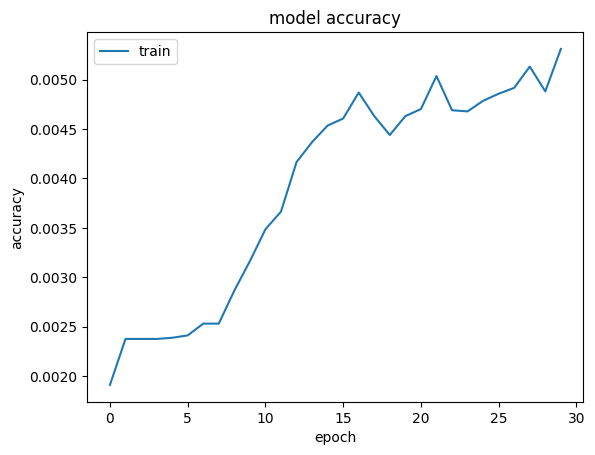

In [547]:
# plot the results of the model
from matplotlib import pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [548]:
# evaluate the test dataset
model.evaluate(
    test_dataset,

)

10/10 [==============================] - 6s 568ms/step - loss: 1.3234 - sparse_categorical_accuracy: 0.0023


[1.3233599662780762, 0.00234113703481853]

# Generate MRR and Precision @ K Metrics Here
- needed parameters for each metric:
1.   **Y_labels/Y_Truth** - the correct answers for each given user/row.
2.   **predicted_Y/y_hat/prediction_labels** - the answers that are models predict.



## Sample Generation of K Items (Optional)

In [112]:
def generate_predictions_based_on_k(k):
  feed = test_dataset
  test_predictions = model.predict(feed)
  prediction_logits = test_predictions[:,-1,:]
  return  prediction_logits, feed

In [ ]:
k = 50

prediction_logits, feed = generate_predictions_based_on_k(k)

y_preds = []
for predictions_logits_sample in prediction_logits:
  top_ratings_indices = predictions_logits_sample.argsort()[-k:][::-1]
  y_preds.append(top_ratings_indices)

y_true_list = []
for batch in feed: # loop through the batch set
  y_true_list.append(batch[1]) # get all 'target' columns from the dataset
y_true = np.concatenate(y_true_list,axis=0) # merge them all into one np array

y_true_latest_job = []
for y_true_val in y_true:
  y_true_latest_job.append(y_true_val[y_true_val != 0][-1]) # this gets the last element from the unpadded (without 0) sequence from the y_labels

In [ ]:
y_true_latest_job

In [ ]:
y_preds

## Generate MRR @ 100 for either Company or Jobs

In [549]:
k  = 100 
prediction_logits, feed = generate_predictions_based_on_k(k)

y_preds = []
for predictions_logits_sample in prediction_logits:
  top_ratings_indices = predictions_logits_sample.argsort()[-k:][::-1]
  y_preds.append(top_ratings_indices)

y_true_list = []
for batch in feed: # loop through the batch set
  y_true_list.append(batch[1]) # get all 'target' columns from the dataset
y_true = np.concatenate(y_true_list,axis=0) # merge them all into one np array

y_true_latest_job = []
for y_true_val in y_true:
  y_true_latest_job.append(y_true_val[y_true_val != 0][-1]) # this gets the last element from the unpadded (without 0) sequence from the y_labels

10/10 [==============================] - 4s 315ms/step


In [550]:
mrr_sum = 0

for latest_job, y_preds_sample,y_true_sample in zip(y_true_latest_job,y_preds,y_true):

  location_indices = np.where(y_preds_sample == latest_job)[0]

  value_exists = np.any(y_preds_sample == latest_job)

  jobs_count = len(y_true_sample[y_true_sample != 0]),

  print('Latest Job: {}\n index where value is found: {} \n Prediction: {}\n Length of y_true:{}'.format(
      latest_job,
      location_indices,
      value_exists,
      jobs_count,
    )
  )

  if value_exists:
    mrr_sum += (1 /(location_indices[0]+1))

Latest Job: 6843
 index where value is found: [] 
 Prediction: False
 Length of y_true:(1,)
Latest Job: 9849
 index where value is found: [] 
 Prediction: False
 Length of y_true:(3,)
Latest Job: 10090
 index where value is found: [] 
 Prediction: False
 Length of y_true:(4,)
Latest Job: 9869
 index where value is found: [] 
 Prediction: False
 Length of y_true:(6,)
Latest Job: 9580
 index where value is found: [] 
 Prediction: False
 Length of y_true:(4,)
Latest Job: 10101
 index where value is found: [] 
 Prediction: False
 Length of y_true:(5,)
Latest Job: 2514
 index where value is found: [] 
 Prediction: False
 Length of y_true:(2,)
Latest Job: 8748
 index where value is found: [] 
 Prediction: False
 Length of y_true:(3,)
Latest Job: 7786
 index where value is found: [] 
 Prediction: False
 Length of y_true:(3,)
Latest Job: 8118
 index where value is found: [] 
 Prediction: False
 Length of y_true:(5,)
Latest Job: 409
 index where value is found: [40] 
 Prediction: True
 Length o

In [551]:
# MRR @ 100 Items
mrr_sum / len(y_preds)

0.004006017420911649

In [552]:
mrr_sum

2.395598417705166

## Precision @ K (where K = 50) for either Company or Jobs


In [553]:
k  = 50

prediction_logits, feed = generate_predictions_based_on_k(50)

y_preds = []
for predictions_logits_sample in prediction_logits:
  top_ratings_indices = predictions_logits_sample.argsort()[-k:][::-1]
  y_preds.append(top_ratings_indices)

y_true_list = []
for batch in feed: # loop through the batch set
  y_true_list.append(batch[1]) # get all 'target' columns from the dataset
y_true = np.concatenate(y_true_list,axis=0) # merge them all into one np array

y_true_latest_job = []
for y_true_val in y_true:
  y_true_latest_job.append(y_true_val[y_true_val != 0][-1]) # this gets the last element from the unpadded (without 0) sequence from the y_labels

10/10 [==============================] - 4s 370ms/step


In [554]:
num_correct = 0
for latest_job, y_preds_sample,y_true_sample in zip(y_true_latest_job,y_preds,y_true):

  location_indices = np.where(y_preds_sample == latest_job)

  value_exists = np.any(y_preds_sample == latest_job)

  print('Latest Job: {}\n index where value is found: {} \n Prediction: {}\n Length of y_true:{}'.format(
      latest_job,
      location_indices,
      # y_preds_sample,
      value_exists,
      # location_indices.size != 0
      len(y_true_sample[y_true_sample != 0]),
    )
  )

  if value_exists:
    num_correct +=1

Latest Job: 6843
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:1
Latest Job: 9849
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:3
Latest Job: 10090
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:4
Latest Job: 9869
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:6
Latest Job: 9580
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:4
Latest Job: 10101
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:5
Latest Job: 2514
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:2
Latest Job: 8748
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:3
Latest Job: 7786
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of

In [555]:
len(y_true_latest_job)

598

In [556]:
num_correct

28

In [557]:
# Precision @ K
num_correct / len(y_preds)

0.046822742474916385

## Precision @ K (where K = 100) for either Company or Jobs


In [558]:
k = 100

prediction_logits, feed = generate_predictions_based_on_k(100)

y_preds = []
for predictions_logits_sample in prediction_logits:
  top_ratings_indices = predictions_logits_sample.argsort()[-k:][::-1]
  y_preds.append(top_ratings_indices)
# y_preds = np.concatenate(y_preds_list,axis=0)

y_true_list = []
for batch in feed: # loop through the batch set
  y_true_list.append(batch[1]) # get all 'target' columns from the dataset
y_true = np.concatenate(y_true_list,axis=0) # merge them all into one np array

y_true_latest_job = []
for y_true_val in y_true:
  y_true_latest_job.append(y_true_val[y_true_val != 0][-1]) # this gets the last element from the unpadded (without 0) sequence from the y_labels

10/10 [==============================] - 8s 768ms/step


In [559]:
num_correct = 0
for latest_job, y_preds_sample,y_true_sample in zip(y_true_latest_job,y_preds,y_true):

  location_indices = np.where(y_preds_sample == latest_job)

  value_exists = np.any(y_preds_sample == latest_job)

  print('Latest Job: {}\n index where value is found: {} \n Prediction: {}\n Length of y_true:{}'.format(
      latest_job,
      location_indices,
      # y_preds_sample,
      value_exists,
      # location_indices.size != 0
      len(y_true_sample[y_true_sample != 0]),
    )
  )

  if value_exists:
    num_correct +=1

Latest Job: 6843
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:1
Latest Job: 9849
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:3
Latest Job: 10090
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:4
Latest Job: 9869
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:6
Latest Job: 9580
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:4
Latest Job: 10101
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:5
Latest Job: 2514
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:2
Latest Job: 8748
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:3
Latest Job: 7786
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of

In [560]:
len(y_true_latest_job)

598

In [561]:
num_correct

36

In [562]:
# Precision @ K
num_correct / len(y_preds)

0.06020066889632107

# Generate MRR, Precision @50 & Precision 100 for  Skills Only

In [ ]:
# change this to either to 50 or 100 depending on what precision @ K to generate.
k = 50 # select how many items to output in terms of predictions. you can change this value to fit your case.

In [ ]:
feed = skills_test_dataset
test_predictions = model.predict(feed)
prediction_logits = test_predictions[:,-1,:]

10/10 [==============================] - 2s 241ms/step


In [ ]:
y_preds = []
for predictions_logits_sample in prediction_logits:
  top_ratings_indices = predictions_logits_sample.argsort()[-k:][::-1]
  y_preds.append(top_ratings_indices)
# y_preds = np.concatenate(y_preds_list,axis=0)

In [ ]:
y_true_list = []
for batch in feed: # loop through the batch set
  y_true_list.append(batch[1]) # get all 'target' columns from the dataset
y_true = np.concatenate(y_true_list,axis=0) # merge them all into one np array

In [ ]:
y_true_latest_job = []
for y_true_val in y_true:
  # if y_true_val.any():
  y_true_latest_job.append(y_true_val[y_true_val != 0]) # this gets the last element from the unpadded (without 0) sequence from the y_labels
  # else:
  #   y_true_latest_job.append([0])

In [ ]:
mrr_sum = 0

# sum_res = []
for y_true_sequence, y_preds_sample,y_true_sample in zip(y_true_latest_job,y_preds,y_true):
  temp_sum = 0
  for sequence_value in y_true_sequence:
    location_indices = np.where(y_preds_sample == sequence_value)[0]

    value_exists = np.any(y_preds_sample == sequence_value)

    jobs_count = len(y_true_sample[y_true_sample != 0]),

    print('Latest Job: {}\n index where value is found: {} \n Prediction: {}\n Length of y_true:{}'.format(
        sequence_value,
        location_indices,
        # y_preds_sample,
        value_exists,
        # location_indices.size != 0
        jobs_count,
      )
    )
    if value_exists:
      temp_sum += (1 /(location_indices[0]+1))
    # print("Temp sum is:",temp_sum)
  mrr_sum += temp_sum/(len(y_true_sequence))
  # print("MRR sum is:",mrr_sum)

Streaming output truncated to the last 5000 lines.
Latest Job: 2888
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 4345
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 148
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 933
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 275
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 37
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 183
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 613
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 145
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 230
 index where value is found: [] 
 Prediction: False
 Length of y_true:(14,)
Latest Job: 860
 index where

In [ ]:
mrr_sum

33.53164013622832

In [ ]:
# MRR @ 100 Items
mrr_sum / len(y_preds)

0.05607297681643532

In [ ]:
num_correct = 0
correct_answers = []
for y_true_sequence, y_preds_sample,y_true_sample in zip(y_true_latest_job,y_preds,y_true):
  temp_sum = 0
  for sequence_value in y_true_sequence:
    location_indices = np.where(y_preds_sample == sequence_value)

    value_exists = np.any(y_preds_sample == sequence_value)

    print('Latest Job: {}\n index where value is found: {} \n Prediction: {}\n Length of y_true:{}'.format(
        sequence_value,
        location_indices,
        # y_preds_sample,
        value_exists,
        # location_indices.size != 0
        len(y_true_sample[y_true_sample != 0]),
      )
    )

    if value_exists:
      correct_answers.append(sequence_value)
      temp_sum +=1
  num_correct += temp_sum/(len(y_true_sequence))

Streaming output truncated to the last 5000 lines.
Latest Job: 2888
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 4345
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 148
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 933
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 275
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 37
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 183
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 613
 index where value is found: (array([], dtype=int64),) 
 Prediction: False
 Length of y_true:14
Latest Job: 145
 index where value is found: (array(

In [ ]:
# Precision @ K
num_correct / len(y_preds)

0.19825545908561293

# Save Models for Export

- Guide: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
saved_model_folder_name = 'Saved_Models/'

model_folder_name = 'skills_prediction_model'

model_folder_dir = configs_data_directory + saved_model_folder_name + model_folder_name

In [ ]:
model.save(model_folder_dir)

In [ ]:
# test out the saved model (optional)

custom_objects = {
    'loss_function':loss_function
}
loaded_model = tf.keras.models.load_model(
    model_folder_dir,
    custom_objects,
)

In [ ]:
loaded_model.evaluate(feed)

44/44 [==============================] - 3s 32ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.1186


[0.05861438810825348, 0.11861861497163773]